In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date,datetime

from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split

print("Setup complete")

#Una de las posibles razones de que las mediciones sean como están es porque una misma estación mide más de una cuenca, por lo que obtener los datos desede
#diferentes sensbilidades es complicado

Setup complete


In [4]:
caudal_data = pd.read_csv('/Users/juanjosegranier/Downloads/caudal_extra.csv') #Acá pueden cambiar la dirección o simplemente bajarlo, como más les convenga

In [5]:
caudal = caudal_data.copy()
caudal['fecha'] = pd.to_datetime(caudal_data['fecha'])

In [6]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max): 
    xaski = (caudal['fecha'] <= fecha_max) & (caudal['fecha'] >= fecha_min)
    columna_0 = caudal.loc[xaski]
    columna_1 = columna_0[columna]
    columna_fecha_0 = caudal.loc[xaski]
    columna_fecha_1 = columna_fecha_0['fecha']
    plt.title("Mediciones de una columna")
    plt.xlabel("Fecha")
    plt.ylabel("Medicion")
    plt.legend()
    plt.plot(columna_fecha_1,columna_1, "b.")
    return ""

In [7]:
def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max): #Probarlo con columnas = ['caudal', 'precip_promedio', 'temp_max_promedio']
    xaski = (caudal['fecha'] <= fecha_max) & (caudal['fecha'] >= fecha_min)
    columna_0 = caudal.loc[xaski]
    columna_10 = columna_0[columnas[0]] #caudal
    columna_11 = columna_0[columnas[1]]*100 #precipitaciones
    columna_12 = columna_0[columnas[2]]*100 #temperatura
    columna_fecha_0 = caudal.loc[xaski]
    columna_fecha_1 = columna_fecha_0['fecha']
    plt.title("Mediciones de varias columnas")
    plt.xlabel("Fecha")
    plt.ylabel("Mediciones")
    plt.legend()
    plt.plot(columna_fecha_1, [columna_10, columna_11, columna_12])
    return ""

In [8]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day) #Para poder particionar en estaciones del año
seasons = [('verano', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('otono', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('invierno', (date(Y,  6, 21),  date(Y,  9, 20))),
           ('primavera', (date(Y,  9, 21),  date(Y, 12, 20))),
           ('verano', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [9]:
caudal['season'] = caudal['fecha'].apply(get_season) #Obtenemos las estaciones del año

In [10]:
tqdm_notebook().pandas() #Para poder ocupar apply con filas

In [11]:
caudal['year'] = caudal.progress_apply(lambda row: row['fecha'].year, axis = 1)

In [12]:
def evento(a):
    if pd.notna(a) == True:  #Nos sirve para obtener contadores binarios como en el caso de las variables extremas, 
                             #así poder obtener los porcentajes de forma más fácil
        return 1
    else:
        return 0

In [14]:
caudal['cauevento'] = caudal.progress_apply(lambda row: evento(row['caudal']), axis = 1)

In [15]:
caudal['tempevento'] = caudal.progress_apply(lambda row: evento(row['temp_max_promedio']), axis = 1)

In [16]:
caudal['precevento'] = caudal.progress_apply(lambda row: evento(row['precip_promedio']), axis = 1)

In [17]:
x_caudal = [[0 for i in range(133)] for i in range(4)]
x_temp =[[0 for i in range(133)] for i in range(4)]
x_precip = [[0 for i in range(133)] for i in range(4)]

In [19]:
estaciones0 = caudal.codigo_estacion.unique()
estaciones = estaciones0.tolist()                     #Creamos listas para indexar mejor
temporadas = ['verano','otono','invierno','primavera']

In [20]:
for estacion in estaciones: #Definimos un arreglo bidimensional para almacenar los valores de los percentiles
    for temporada in temporadas:
        caudalis = caudal.loc[caudal.codigo_estacion == estacion]
        caudalis2 = caudalis.loc[caudalis.season == temporada]
        i = temporadas.index(temporada)
        j = estaciones.index(estacion)
        x_caudal[i][j] = np.percentile(caudalis2['caudal'],95) 
        x_temp[i][j] = np.percentile(caudalis2['temp_max_promedio'],95)
        x_precip[i][j] = np.percentile(caudalis2['precip_promedio'],95)

//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [21]:
def p95_caudal(estacion):
    i = estaciones.index(estacion)
    return [x_caudal[0][i], x_caudal[1][i], x_caudal[2][i], x_caudal[3][i]]

def p95_temp(estacion):
    i = estaciones.index(estacion)
    return [x_temp[0][i],  x_temp[1][i], x_temp[2][i], x_temp[3][i]] #Primero obtenemos arreglos, luego proyectamos

def p95_precip(estacion):
    i = estaciones.index(estacion)
    return [ x_precip[0][i], x_precip[1][i], x_precip[2][i] , x_precip[3][i]]

In [22]:
caudal['p95c'] = ''
caudal['p95p'] = ''
caudal['p95t'] = ''

In [23]:
caudal['p95c'] = caudal['codigo_estacion'].apply(p95_caudal)
caudal['p95t'] = caudal['codigo_estacion'].apply(p95_temp) #Obtenemos los arreglos con los 4 posibles valores segun las estaciones del año por fila
caudal['p95p'] = caudal['codigo_estacion'].apply(p95_precip)

In [24]:
def elemento(a,b):
    i = temporadas.index(b) #Con esto obtenemos el elemento específico del arreglo
    return a[i]

In [25]:
caudal['p95cdef'] = caudal.progress_apply(lambda row: elemento(row['p95c'], row['season']), axis = 1)


In [26]:
caudal['p95tdef'] = caudal.progress_apply(lambda row: elemento(row['p95t'], row['season']), axis = 1 )

In [27]:
caudal['p95pdef'] = caudal.progress_apply(lambda row: elemento(row['p95p'], row['season']), axis = 1)

In [28]:
def extremo(a,b):
    if a >= b:
        return 1 #Con este método obtenemos finalmente las variables booleanas extremas, a decir verdad es una buena idea poder comparar con un 95% de la muestra y tener un 5% superior, aunque podríamos considerarlo hasta el día anterior
    else:
        return 0

In [29]:
caudal['caudal_extremo'] = caudal.progress_apply(lambda row: extremo(row['caudal'], row['p95cdef']), axis = 1)

In [30]:
caudal['temp_extremo'] = caudal.progress_apply(lambda row: extremo(row['temp_max_promedio'], row['p95tdef']), axis = 1)

In [33]:
caudal['precip_extremo'] = caudal.progress_apply(lambda row: extremo(row['precip_promedio'], row['p95pdef']), axis = 1)

In [ ]:
caudal.groupby('gauge_id').caudal_extremo.value_counts() #Podemos observar que hay grandes diferencias en las cuencas, esto pues pueden haber mediciones desde más de una estación. También pueden hacer un scatter condierando datos como latitud y longitud versus las ocurrencias extremas totales

In [34]:

x2_caudal = [0 for i in range(59)]
x2_temp = [0 for i in range(59)]
x2_prep = [0 for i in range(59)]

y2_caudal = [0 for i in range(59)] #Con esta matriz obtenemos los porcentajes
y2_temp = [0 for i in range(59)]
y2_prep = [0 for i in range(59)]

z2_caudal = [0 for i in range(59)]
z2_temp = [0 for i in range(59)]
z2_prep = [0 for i in range(59)]

In [ ]:
#caudal = caudal_set.index('year') #Es una posibilidad indexar por año para obtener mejores resultados al graficar

In [35]:
hola_caudal = caudal.groupby('year').cauevento.value_counts().sort_index()
hola_temp = caudal.groupby('year').tempevento.value_counts().sort_index()
hola_prep = caudal.groupby('year').precevento.value_counts().sort_index()
hola2_caudal = caudal.groupby('year').caudal_extremo.value_counts().sort_index()
hola2_temp = caudal.groupby('year').temp_extremo.value_counts().sort_index()
hola2_prep = caudal.groupby('year').precip_extremo.value_counts().sort_index()

In [36]:
for i in range(59):
    x2_caudal[i] = hola_caudal[i]
    x2_temp[i] = hola_temp[i]
    x2_prep[i] = hola_prep[i]
    y2_caudal[i] = hola2_caudal[2*i+1]
    y2_temp[i] = hola2_temp[2*i + 1]
    y2_prep[i] = hola2_prep[2*i+1]
    z2_caudal[i] = (y2_caudal[i]/x2_caudal[i])*100
    z2_temp[i] = (y2_temp[i]/x2_temp[i])*100
    z2_prep[i] = (y2_prep[i]/x2_prep[i])*100

In [39]:
years = caudal.year.unique().tolist()

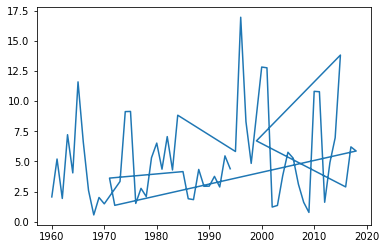

In [45]:
plt.plot(years,z2_caudal) #En esta parte pueden probar por z2_prep, z2_temp. Notar que hay valores que se disparan. Esto último puede ser porque los valores obtenidos no están bien indexados con 'years'